# Online Reviews Classification

## Table of Contents:
* [Introduction and Research Question](#1-bullet)
* [Dataset](#2-bullet)
* [Load and Clean the Data](#3-bullet)
* [Descriptive Statistics](#4-bullet)
* [Preprocessing](#5-bullet)
* [Neural Network](#6-bullet)
* [Sources](#11-bullet)


# Introduction and research question <a class="anchor" id="1-bullet"></a>

As online shopping is one of the most popular online activities worldwide (NTIA 2019), the product reviews and ratings have become of significant relevance. In a survey with 2,000 consumers, conducted in the U.S., 93% of the respondents claim that reviews influenced their purchase decision (Podium, 2018). The same study reveals that two-thirds of the consumers would be able to pay 15% more for the same product if they were told that the product has a good customer experience.

In this project, we examine the suitability of Neural Networks (NN) for the classification of reviews as positive or negative. To see how well NN perform, we compare it with the Multinomial Naive Bayes Classifier. We identify whether the review for the product is positive or negative based on the reviews and ratings provided by other customers. This helps to analyze products’ reviews on platforms that do not have a rating option - such as Twitter or other social media.

# Dataset <a class="anchor" id="2-bullet"></a>

For the project, we use a datasets that contains Amazon reviews with ratings, which we take from kaggle.com. The training data contains 3,600,000 reviews whereas the testing data contains 400,000 reviews in total. The ratings in the dataset are presented in the following way: one- and two-star ratings have the value 1, whereas four- and five-star ratings have the value 2. The three-star ratings are not included in the dataset, because they do not help to classify the reviews as positive or negativ.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from nltk.stem import PorterStemmer
import time

# Load and Clean the data <a class="anchor" id="3-bullet"></a>

We used the function load_data to load the raw data into a pandas dataframe. In the data cleaning process, we first define the path of the dataset, in which we splite the data, rename columns to label and text, change the label from string to number and change the number of rows.

In [2]:
# data_path: path of dataset
# max_rows: maximum number of rows

def load_data(data_path, max_rows):
    # read data
    df = pd.read_csv(data_path,sep='\t', header=None)
    # split data in label and text
    df = df[0].str.split(' ', n=1, expand=True)
    # rename columns
    df = df.rename(columns={0: "label", 1: "text"})
    # change label form string to number
    df['label'] = df['label'].str[-1]
    # change number of rows
    if df.shape[0]> max_rows:
        df = df.iloc[0:max_rows]
    return df

Having performed this step, we defined the length of the training and test dataset. For the training dataset, we used 360,000 reviews, whereas for the testing dataset we used 40,000 reviews. We decided to shrink the number of reviews and ratings to quickly run and compare different models. The possible consequences of shrinking the datasets will be also discussed later.

In [3]:
# define lengths of training and testing data

n_train = 360000
n_test = 40000

In [4]:
# load training and testing data

df_train = load_data('data/train.txt', n_train)
df_test = load_data('data/test.txt', n_test)

In [5]:
# show training data

df_train.head()

,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


# Descriptive Statistics<a class="anchor" id="4-bullet"></a>

Once we loaded the data, we observed the label and text columns in more details.

In [6]:
# ratings

df_train['label'].describe()

count     360000
unique         2
top            2
freq      182351
Name: label, dtype: object

In [7]:
# include the numer of characters of the texts in the dataframe

df_train['len'] = df_train['text'].str.len()

df_train.head()

,label,text,len
0,2,Stuning even for the non-gamer: This sound tra...,426
1,2,The best soundtrack ever to anything.: I'm rea...,509
2,2,Amazing!: This soundtrack is my favorite music...,760
3,2,Excellent Soundtrack: I truly like this soundt...,743
4,2,"Remember, Pull Your Jaw Off The Floor After He...",481


We also included the length of the text in the data frame. In the histogram given below, the distribution of review length can be observed. The average length of the train data reviews is 440 characters, whereas the maximum and minimum lengths are 1015 and 97, respectively. We notice that negative reviews are slightly longer than the positive ones (456 and 423, respectively).

In [8]:
# analyze the lenth of the texts

df_train['len'].describe()

count    360000.000000
mean        439.802650
std         239.861798
min          97.000000
25%         237.000000
50%         393.000000
75%         608.000000
max        1015.000000
Name: len, dtype: float64

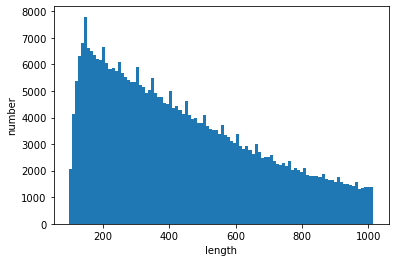

In [9]:
# plot distribution of the lenght of the reviews

plt.hist(df_train['len'], bins=100)  # density=False would make counts
plt.ylabel('number')
plt.xlabel('length');

In [10]:
# compare length of revies by rating

df_train.groupby(['label']).mean()

,len
label,
1,456.136224
2,423.890245


In [11]:
# standard deviation

df_train.groupby(['label']).std()

,len
label,
1,237.500182
2,241.079158


# Preprocessing<a class="anchor" id="5-bullet"></a>

In this section, we prepared and cleaned the text data and made it ready to feed it to the model. The transform_data method takes a dataframe, the ngram specification, a list of words or the maximum number of features for which the matrix of token counts should be created. If the list of words vocab is set to None, max_feat is used, else the list of words is created automatically.

In [12]:
def transform_data(df, ngram, vocab, max_feat):
    
    # tokenization
    rx = '[a-zA-Z]{3,20}'
    cv = CountVectorizer(vocabulary=vocab, ngram_range=ngram, max_df=0.95, min_df=3, max_features=max_feat, stop_words='english', token_pattern = rx)
    cvf = cv.fit_transform(df['text'])
    words = cv.get_feature_names()
    
    # word matrix
    count_vect_df = pd.DataFrame(cvf.todense(), columns=cv.get_feature_names())
    
    # input and output data
    x = count_vect_df.to_numpy()
    y = df['label'].to_numpy().astype(int)
    # change 1 to 0 and 2 to 1
    y = np.where(y==1, 0, 1)
    
    # results
    output = [words, x, y]
    return output

In [13]:
# define maximum number of features

max_feat = 100

## Training data

In [14]:
# transform training data
# we set vocab to None in order to automatically create a list of words

train_data = transform_data(df_train,(1,1), None, max_feat)

After performing the transform_data method for the training data, we obtained a list with three elements. The first one consists of a list with the 100 most frequent words, because we set the vovabulary to None - this created automatically a list of most frequent words.

In [15]:
# words

train_data[0]

['actually',
 'album',
 'amazon',
 'author',
 'bad',
 'best',
 'better',
 'big',
 'book',
 'books',
 'boring',
 'bought',
 'buy',
 'characters',
 'come',
 'day',
 'did',
 'didn',
 'different',
 'disappointed',
 'does',
 'doesn',
 'don',
 'dvd',
 'easy',
 'end',
 'excellent',
 'fan',
 'far',
 'feel',
 'film',
 'fun',
 'game',
 'going',
 'good',
 'got',
 'great',
 'hard',
 'interesting',
 'just',
 'know',
 'life',
 'like',
 'little',
 'long',
 'look',
 'looking',
 'lot',
 'love',
 'make',
 'makes',
 'money',
 'movie',
 'movies',
 'music',
 'need',
 'new',
 'nice',
 'old',
 'people',
 'plot',
 'pretty',
 'price',
 'product',
 'quality',
 'read',
 'reading',
 'real',
 'really',
 'recommend',
 'reviews',
 'right',
 'say',
 'series',
 'set',
 'song',
 'songs',
 'sound',
 'story',
 'sure',
 'thing',
 'things',
 'think',
 'thought',
 'time',
 'times',
 'use',
 'used',
 'version',
 'want',
 'waste',
 'watch',
 'way',
 'work',
 'works',
 'world',
 'worth',
 'written',
 'year',
 'years']

The second consists of a vector with a length of the entire vocabulary – namely, 100 words - and an integer count for the number of times each word appeared in each of the reviews.

In [16]:
# word-count-matrix

train_data[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

The third and final output, consists of a single vector of ratings with values 1 and 2.

In [17]:
# ratings

train_data[2]

array([1, 1, 1, ..., 0, 0, 1])

## Test data

We applied the same function to the test dataset and used the list of words created for the training data such that the list of words for the test dataset is the same list as one for the training data.

In [18]:
# transform test dataset
# we set vocab to the automatically created wordlist of the traning dataset "train_data[0]"

test_data = transform_data(df_test,(1,1), train_data[0], max_feat)

# Neural Network<a class="anchor" id="6-bullet"></a>

In [19]:
# reshape data for NN

num_classes = None

x_train = train_data[1].reshape(360000, max_feat)
x_test = test_data[1].reshape(40000, max_feat)
y_train = train_data[2].reshape(360000, 1)
y_test = test_data[2].reshape(40000, 1)

In [20]:
# Build NN

batch_size = 1
epochs = 3

model = Sequential()
model.add(Dense(max_feat, activation='relu', input_shape=(max_feat,)))
model.add(Dense(100, activation='relu', input_shape=(100,)))
model.add(Dense(100, activation='relu', input_shape=(100,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In the next step, the model was trained based on the defined parameters and afterwards evaluated. As you can see below, the validation loss was about 49% and the validation accuracy was close to 76%, which is quite close to the results of the model which indicates, for example, that the model is not overfitted.

In [21]:
# Train and evaluate the model

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/3
11250/11250 [==============================] - 10s 844us/step - loss: 0.5038 - accuracy: 0.7474 - val_loss: 0.4926 - val_accuracy: 0.7559
Epoch 2/3
11250/11250 [==============================] - 9s 802us/step - loss: 0.4905 - accuracy: 0.7564 - val_loss: 0.4899 - val_accuracy: 0.7560
Epoch 3/3
11250/11250 [==============================] - 9s 814us/step - loss: 0.4854 - accuracy: 0.7597 - val_loss: 0.4878 - val_accuracy: 0.7572
Test loss: 0.48778119683265686
Test accuracy: 0.7571750283241272


Finally, we set up a function to predict whether a review is bad or good. This was done by converting the new review to a vector of token numbers and using a built-in list to exclude stop words. We then converted the matrix into a data frame, which allowed us to perform the prediction. The prediction either gives back a 0 for a bad review or a 1 for a good review. Below are three examples of bad ratings and the (correct) output of the prediction.

In [22]:
# function to predict if a rewiew is positive of negative
# 0: bad review
# 1: good review

def test_string(test_text, model, vocab):
    # tokenization
    rx = '[a-zA-Z]{3,20}'
    cv = CountVectorizer(vocabulary=vocab, stop_words='english', token_pattern = rx)
    cvf = cv.fit_transform([test_text])
    # convert matrix to dataframe
    output = pd.DataFrame(cvf.todense(), columns=cv.get_feature_names())
    # prediction
    x = np.argmax(model.predict(output.to_numpy()))
    return x

In [23]:
# test the model

text1 = "Really impressive for £319. Obviously that’s still a lot of money but with the pro pretty much 3x that and most competitors higher the quality for price is brilliant. Great screen quality and super quick."
text2 = "Believed I was buying the new mobile I pad, needed up with the old model"
text3 = "I agree on other comments that feet are a nightmare to get on,! Picture quality nice and sharp so no problems there however it takes forever to load. I have never had a tv so slow to load. It is very frustrating. I am about to buy another tv for another room and it will not be one of these. I would also add it is not a broadband issue. It is the tv. Update. After nearly two months this tv is getting slower and slower. It is almost impossible to use. A month ago I bought a Hisense tv for another room and it works perfectly. Avoid this JVC. It is so bad it is best classed as junk"

test_string("bad product", model, train_data[0])

0

# Sources <a class="anchor" id="11-bullet"></a>

Dataset: https://www.kaggle.com/bittlingmayer/amazonreviews